In [151]:
import pandas as pd
import numpy as np

import math
from math import floor

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_df = pd.read_csv('data/train_cleaned.csv')
test_df = pd.read_csv('data/test_cleaned.csv')

### Join DataFrames drop survived

In [3]:
drop_col = ['survived', 'first_name', 'last_names', 'ticket', 'cabin', 'embarked', 'passengerid']
df = pd.concat([train_df, test_df])
df.drop(drop_col,axis=1, inplace=True)

---
## Re-distribute data 
- train_age-[no null values in age]
- null_age-[age null values]

In [4]:
null_age = df[df.age.isnull()].drop('age',axis=1)
train_age = df[df.age.notnull()]
train_age.head(3)

,pclass,sex,age,sibsp,parch,fare,title
0,3,1,22.0,1,0,7.2500,mr
1,1,0,38.0,1,0,71.2833,mrs
2,3,0,26.0,0,0,7.9250,miss


### Exploring new data

#### Notes:
Preprocessing:  
- Standardization required
- One hot encoder for title features

Anomalies:
- min_age == 0.17?
- math.floor() age [any one younger than 1 year] -> 0 years old, also removes any other floats from age column

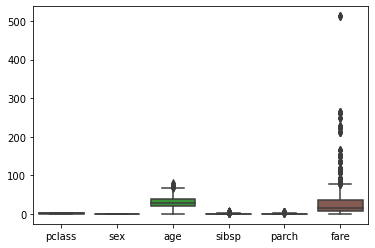

pclass      int64
sex         int64
age       float64
sibsp       int64
parch       int64
fare      float64
title      object
dtype: object
----------------------------------------------------------------------------------
            pclass          sex          age        sibsp       parch  \
count  1046.000000  1046.000000  1046.000000  1046.000000  1046.00000   
mean      2.207457     0.629063    29.881138     0.502868     0.42065   
std       0.841497     0.483287    14.413493     0.912167     0.83975   
min       1.000000     0.000000     0.170000     0.000000     0.00000   
25%       1.000000     0.000000    21.000000     0.000000     0.00000   
50%       2.000000     1.000000    28.000000     0.000000     0.00000   
75%       3.000000     1.000000    39.000000     1.000000     1.00000   
max       3.000000     1.000000    80.000000     8.000000     6.00000   

              fare  
count  1046.000000  
mean     36.685068  
std      55.705870  
min       0.000000  
25%       8.05

In [5]:
sns.boxplot(data=train_age)
plt.show()

print(train_age.dtypes, end='\n----------------------------------------------------------------------------------\n')
print(train_age.describe())

In [6]:
train_age.loc[(train_age.age < 18)&(train_age.title == 'mrs')]

,pclass,sex,age,sibsp,parch,fare,title
9,2,0,14.0,1,0,30.0708,mrs
307,1,0,17.0,1,0,108.9000,mrs
781,1,0,17.0,1,0,57.0000,mrs
830,3,0,15.0,1,0,14.4542,mrs
104,3,0,16.0,1,1,8.5167,mrs


### Preprocessing

In [44]:
train_age.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'title'], dtype='object')

In [129]:
transformer = ColumnTransformer([('one_hot', OneHotEncoder(), ['title']),
                                 ('standardize', StandardScaler(), ['pclass', 'sibsp', 'parch', 'fare'])],
                                 remainder='passthrough')


<AxesSubplot:>

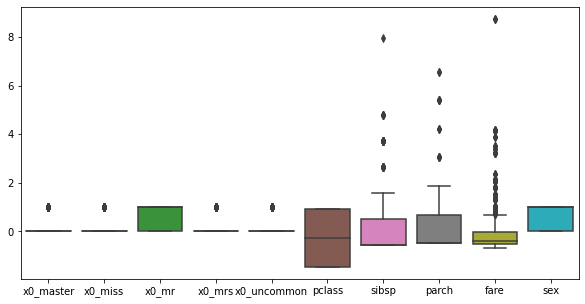

In [133]:
X = train_age.drop('age',axis=1)
y = [floor(age) for age in train_age['age']]


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=22)

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

# Get column names
columns = transformer.named_transformers_['one_hot'].get_feature_names()
columns = np.append(columns, ['pclass', 'sibsp', 'parch', 'fare', 'sex'])

# Convert to DataFrame
df = pd.DataFrame(X_train, columns=columns)

# Plot
fig = plt.figure(figsize=(10,5))
sns.boxplot(data=df)

In [191]:
def regression_results(predictions, actual):
    df = pd.DataFrame({'predictions':predictions,
                       'actual':actual})
    df['squared_differences'] = (df.actual - df.predictions) ** 2
    df['error_square_root'] = [math.sqrt(value) for value in df.squared_differences]
    return df

In [192]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression().fit(X_train, y_train)
predictions = clf.predict(X_test)

df = regression_results(predictions, y_test)

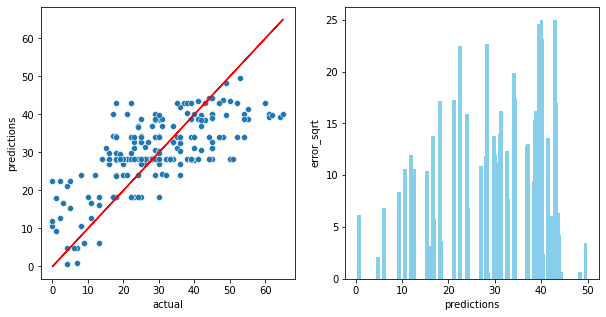

In [240]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.scatterplot(data=df, x='actual', y='predictions', ax=ax[0])
ax[0].plot(y_test,y_test, 'r')

ax[1].bar(df.predictions, df.error_square_root, color='skyblue')
ax[1].set_xlabel('predictions')
ax[1].set_ylabel('error_sqrt')

fig.subplots_adjust(wspace=0.2)

In [245]:
bad_pred = df[df.error_square_root > 15]
good_pred = df[df.error_square_root < 5]

In [258]:
bad_values

18    4
61    3
44    2
54    2
17    2
0     1
1     1
60    1
22    1
55    1
21    1
52    1
51    1
5     1
64    1
15    1
45    1
50    1
65    1
8     1
4     1
2     1
62    1
Name: actual, dtype: int64

<BarContainer object of 23 artists>

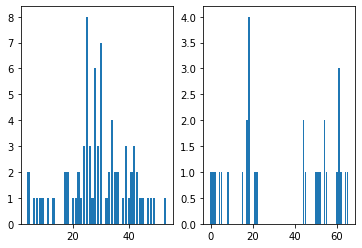

In [255]:
good_values = good_pred.actual.value_counts()
bad_values = bad_pred.actual.value_counts()

fig, ax = plt.subplots(1,2)
ax[0].bar(good_values.index, good_values.values)
ax[1].bar(bad_values.index, bad_values.values)